In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import os
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable

Text(0, 0.5, 'Promoter supercoiling density')

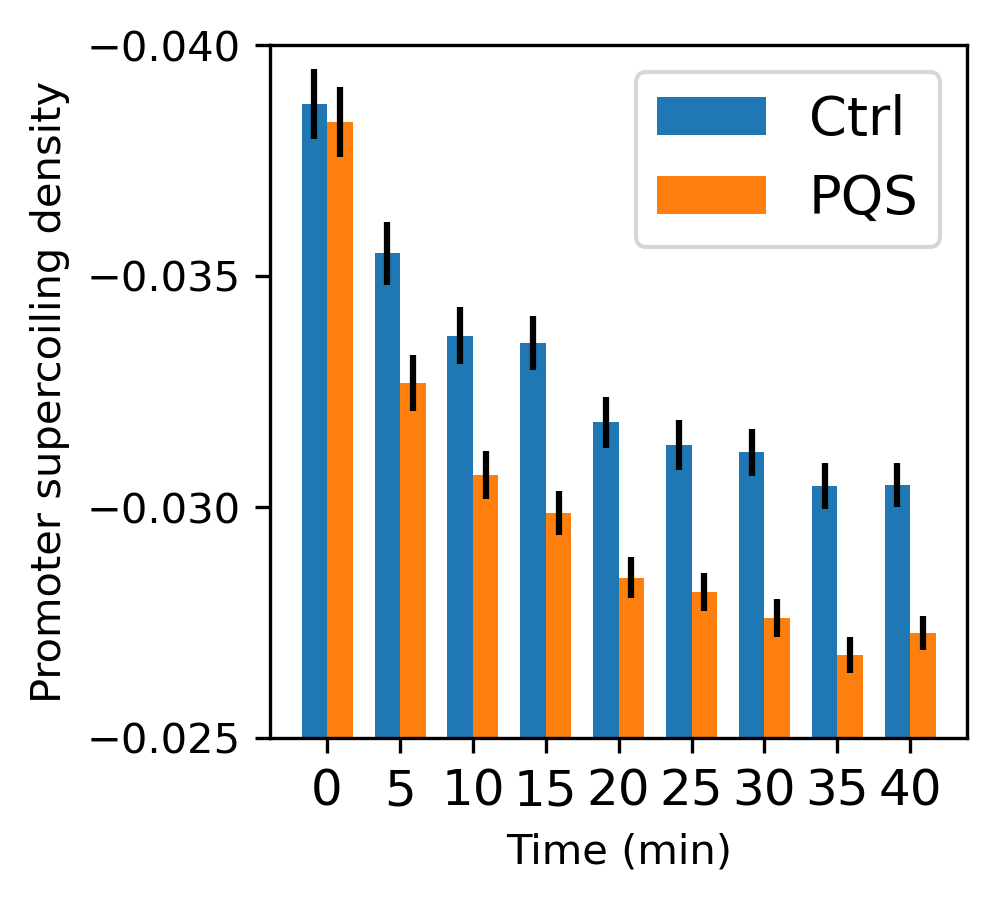

In [2]:
time_points=np.arange(0,45,5)
GQ_on_id=0
eR_on_id=0
topo_id=0
path="/scratch/sb95/R-loop/Runs_eRoff/sig-0.06/outputfiles/"

sigma = [[[] for _ in range(len(time_points))], [[] for _ in range(len(time_points))]]
sigma_sd = [[[] for _ in range(len(time_points))], [[] for _ in range(len(time_points))]]
for PQS_id in [0,1]:
    
    for replica in range(128):

        dfsig = pd.read_table(os.path.join(path,f"RUN_0_0_{GQ_on_id}_{eR_on_id}_{topo_id}_0_{PQS_id}/promsynced_sigma_{replica}.log"), 
                        delimiter=" ", names=['time','TSS','TTS'])

        for ii, time in enumerate(time_points):
            prom_sig = dfsig.query(f"{time*60}<time<{time*60+200}")['TSS'].values
            sigma[PQS_id][ii].append(prom_sig.mean())
            sigma_sd[PQS_id][ii].append(sp.stats.sem(prom_sig))

fig,ax = plt.subplots(1,1, figsize=(3,3), dpi=300, gridspec_kw={'wspace':0.35, 'hspace':0.35})
width=0.35
x = np.arange(len(time_points))
ax.bar(x-width/2,[np.mean(sigma[0][xx]) for xx in range(len(time_points))], width,#label='Ctrl',
        yerr= [np.mean(sigma_sd[0][xx]) for xx in range(len(time_points))],  label='Ctrl')
            
ax.bar(x+width/2,[np.mean(sigma[1][xx]) for xx in range(len(time_points))], width,#label='PQS')
        yerr= [np.mean(sigma_sd[1][xx]) for xx in range(len(time_points))], label='PQS')

with open("CTRL-sc.txt", 'w') as fo:
    for xx in range(len(time_points)):
        fo.write(f"{np.mean(sigma[0][xx])}\t {np.mean(sigma_sd[0][xx])}\n")

with open("PQS-sc.txt", 'w') as fo:
    for xx in range(len(time_points)):
        fo.write(f"{np.mean(sigma[1][xx])}\t {np.mean(sigma_sd[1][xx])}\n")

# ax.bar(x+width/2,sigma[1],width, label='PQS')
ax.set_ylim(-0.025,-0.04)
ax.set_xticks(x)
ax.set_yticks([-0.025,-0.03, -0.035, -0.04])
# ax.set_yticklabels([-0.025,-0.03, -0.035, -0.04], fontsize=12)
ax.set_xticklabels(time_points, fontsize=12)
ax.legend(fontsize=13)


ax.set_xlabel("Time (min)")
ax.set_ylabel("Promoter supercoiling density")

replica 45
2048.19


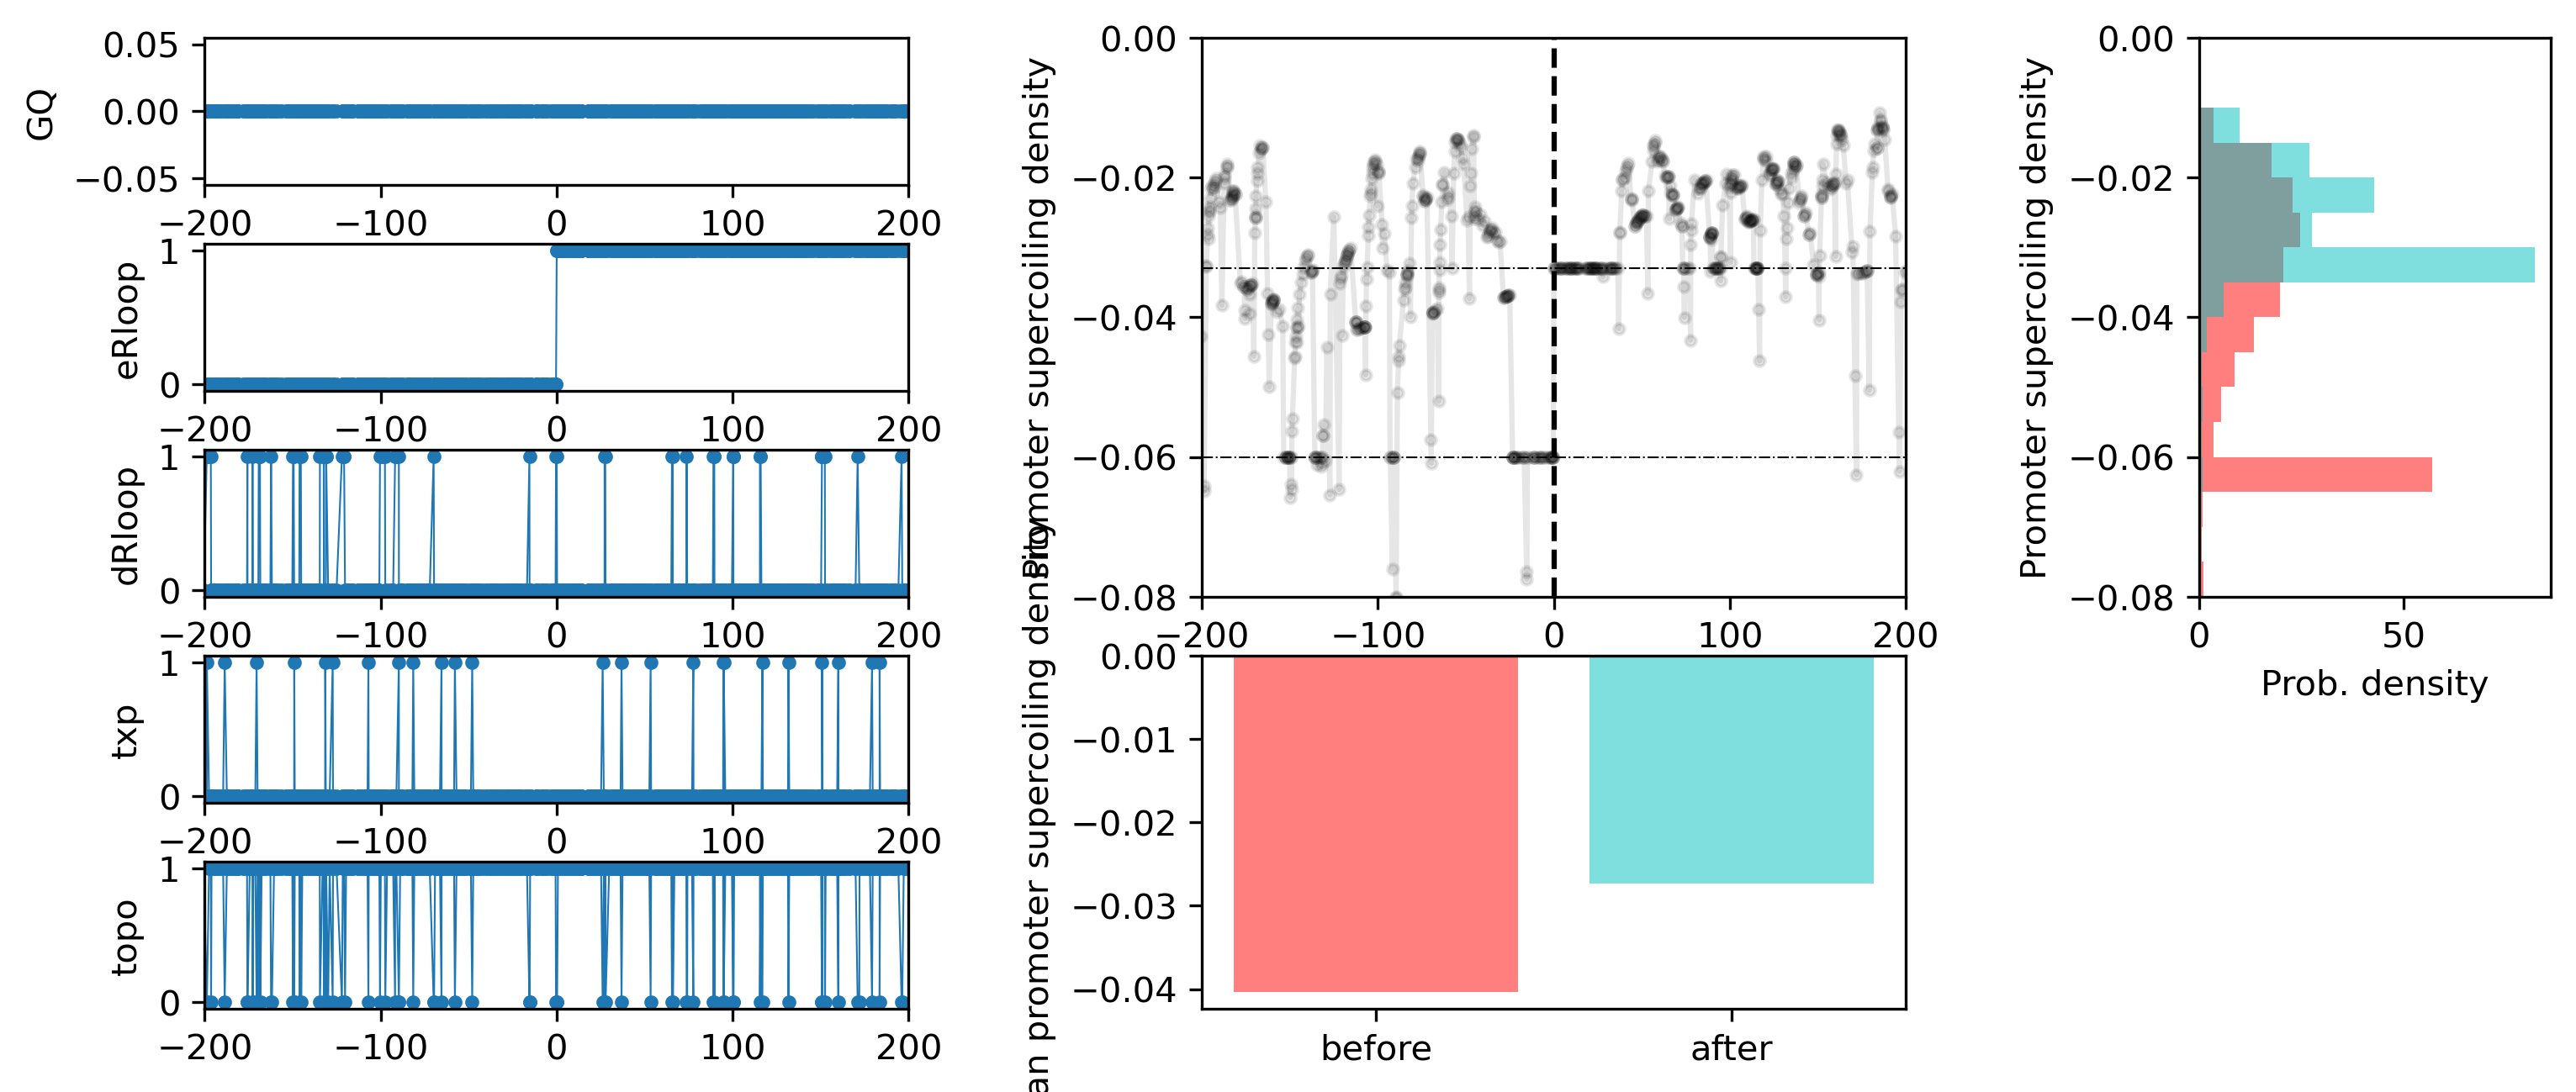

In [5]:
GQ_on_id=0
eR_on_id=0
topo_id=0
PQS_id=1

dt=400

fig,ax = plt.subplot_mosaic("ABE\nCBE\nDBE\naF.\nbF.", figsize=(12,5), dpi=300, gridspec_kw={'width_ratios':[1,1,0.5], 'wspace':0.5, 'hspace':0.4})

sigma_before=[]
sigma_after=[]
ii=-1
for replica in np.random.randint(20,127,1):
# for replica in (np.random.randint(16,127),):
    print("replica",replica)

    ii+=1
    try:
        dfsig = pd.read_table(os.path.join(path,f"RUN_0_0_{GQ_on_id}_{eR_on_id}_{topo_id}_0_{PQS_id}/promsynced_sigma_{replica}.log"), 
                            delimiter=" ", names=['time','TSS','TTS'], skiprows=1)
        df = pd.read_table(os.path.join(path,f"RUN_0_0_{GQ_on_id}_{eR_on_id}_{topo_id}_0_{PQS_id}/sua_{replica}.log"), 
                            delimiter="\t", names=['time','dR','GQ','eR'], skiprows=1)
        
        dfevents = pd.read_table(os.path.join(path,f"RUN_0_0_{GQ_on_id}_{eR_on_id}_{topo_id}_0_{PQS_id}/event_{replica}.log"), 
                            delimiter=" ", names=['time','event'])
        dfevents.tail(-1)
    except FileNotFoundError: 
        print("no file found")
        continue
    
    assert df.shape[0]!=0 and dfsig.shape[0]!=0 and dfevents.shape[0]!=0
    
    #find eR nucleation time
    eR_nucl_times = df.query("eR==1")["time"].values

    if len(eR_nucl_times)==0: 
        print("No eR nucleation")
        continue
    else:
        eR_nucl_time = min(eR_nucl_times)


    print(eR_nucl_time)  
    events = df.query(f"{eR_nucl_time-dt}<time<{eR_nucl_time+dt}")
    
    ax['A'].plot(events["time"].values-eR_nucl_time, events["GQ"].values,'.-',lw=0.5)
    ax['C'].plot(events["time"].values-eR_nucl_time, events["eR"].values,'.-',lw=0.5)
    ax['D'].plot(events["time"].values-eR_nucl_time, events["dR"].values,'.-',lw=0.5)
    
    txp = dfevents.query(f"{eR_nucl_time-dt}<time<{eR_nucl_time+dt}")['event']==0
    plect_relax = dfevents.query(f"{eR_nucl_time-dt}<time<{eR_nucl_time+dt}")['event']==2
    ax['a'].plot(events["time"].values-eR_nucl_time, txp,'.-',lw=0.5)
    ax['b'].plot(events["time"].values-eR_nucl_time, plect_relax,'.-',lw=0.5)

    sig = dfsig.query(f"{eR_nucl_time-dt}<time<{eR_nucl_time+dt}")['TSS']
    
    # ax['B'].plot(events["time"].values-eR_nucl_time, sig,'.',c="0.05", alpha=0.002)
    ax['B'].plot(events["time"].values-eR_nucl_time, sig,'.-',c="0.05", alpha=0.1)
    ax['B'].axvline(0,c='k', ls='--')

    sigma_before.append(dfsig.query(f"{eR_nucl_time-dt}<time<{eR_nucl_time}")['TSS'].values)
    sigma_after.append(dfsig.query(f"{eR_nucl_time}<time<{eR_nucl_time+dt}")['TSS'].values)
sigma_after = np.concatenate(sigma_after)
sigma_before = np.concatenate(sigma_before)
ax['F'].bar(['before','after'],[np.mean(sigma_before),np.mean(sigma_after)],color=['r','c'], alpha=0.5)
p=ax['E'].hist(sigma_before,  bins=np.arange(-0.1,0.1,0.005), density=True, alpha=0.5, orientation="horizontal", color='r',label="before")
p=ax['E'].hist(sigma_after,  bins=np.arange(-0.1,0.1,0.005), density=True,alpha=0.5, orientation="horizontal", color='c',label="after")

# print(txp)
ax['A'].set_ylabel("GQ")
ax['C'].set_ylabel("eRloop")
ax['D'].set_ylabel("dRloop")
ax['a'].set_ylabel("txp")
ax['b'].set_ylabel("topo")
ax['B'].set_ylabel("Promoter supercoiling density")
ax['E'].set_ylabel("Promoter supercoiling density")
ax['B'].set_ylim(-0.08,0.0)
ax['E'].set_ylim(-0.08,0.0)
ax['B'].set_xlabel("Time (sec)")
ax['D'].set_xlabel("Time (sec)")
ax['E'].set_xlabel("Prob. density")

ax['F'].set_ylabel("Mean promoter supercoiling density")
ax['B'].axhline(-0.06, c='k',lw=0.5,ls='-.',zorder=-1)
ax['B'].axhline(-0.033, c='k',lw=0.5,ls='-.',zorder=-1)
# ax['B'].axhline(-0.05, c='k',lw=0.5,ls='-.',zorder=-1)
for axi in [ax['A'],ax['C'],ax['D'],ax['a'],ax['b'], ax['B'] ]:
    axi.set_xlim(-dt/2,dt/2)
